In [155]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
from ast import literal_eval

def find_data_paths(sleep_path, mouse):
    all_mice_dict = {}
    for i,file in enumerate(os.listdir(sleep_path)):
        if mouse in file:
            paths_dict = {}
            mir = file.split('run')[0][0:-1]
            paths_dict['sleep_path'] = sleep_path + file
            awake_base = os.path.join(remove_last_folder(sleep_path), 'awake')
            for awake_file in os.listdir(awake_base):
                if mir in awake_file:
                    paths_dict['awake_path'] = os.path.join(awake_base, awake_file)
            try: 
                paths_dict['full_org_dat_path'] = find_organised_path('EJT' + mir,r"Z:\projects\sequence_squad\organised_data\animals\\")
            except:
                paths_dict['full_org_dat_path']  = find_organised_path(mir,r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\")
            all_mice_dict[mir] = paths_dict
    return all_mice_dict

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path



def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()



In [140]:
sleep_pp_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\"
# expert_mice = [item.split('run')[0][0:-1] for item in os.listdir(awake_pp_path)]

In [141]:
all_mice_df = pd.DataFrame({})
for mouse in [item.split('_run')[0] for item in os.listdir(sleep_pp_path)]:
    if '.csv' in mouse:
        continue
    print(mouse)
    
    
    mouse_path_dict = find_data_paths('Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\',mouse)
    
    
    current_mouse_replay_path = mouse_path_dict[mouse]['sleep_path'] + '\\_final_analysis_output'
    
    if '_final_analysis_output' in os.listdir(mouse_path_dict[mouse]['sleep_path']):
        # load in sleep start time 
        sleep_time_point_df = pd.read_csv(remove_last_folder(mouse_path_dict[mouse]['sleep_path']) + '\sleep_time_points.csv')
        current_sleep_start = sleep_time_point_df['approx_sleep_start'][np.where(sleep_time_point_df.mir == mouse)[0][0]]
        params_file = mouse_path_dict[mouse]['sleep_path'] + r'\trainingData\\' + 'params_' + mouse + '.json'
        with open(params_file, 'r') as file:
            params = json.load(file)
        time_spans = params['time_span']
        
        # load sequence order
        sequence_order = pd.read_csv(r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\" + r'\sequence_order.csv')
        
        mir_row = None
        for ind, row in sequence_order.iterrows():
            if row.mir in mouse:
                mir_row = row
        seq_order = literal_eval(mir_row.seq_order)
    
    total_seqs_chunk = []
    ## loop across all chunk files ################################
    for chunk_number,file in enumerate(os.listdir(current_mouse_replay_path)):
        if not 'chunk' in file:
            continue
        print(file)
        current_data_path = current_mouse_replay_path + '\\' + file + '\\'
        chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
        data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')

        ###### FILTERING AND MASKING ##################################################################''
        ## filter this data for sequential ordering
        sequential_condition = data.ordering_classification == 'sequential'
        # filter is set up so that any true will carry forward 
        filtered_chunk_data = data[sequential_condition].reset_index()
        
        ## REM / NREM times only
        # load in sleep state scoring
        nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(mouse)
        # get relevant rem/nrem times for chunk
        chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
        chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
        # get spike times relative to chunk:
        chunk_number = int(file.split('_')[0][-1])
        chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
        # make relative to start of chunk
        fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
        # find inds of spike times that are in nrem and rem periods:
        idx  = []
        for start,end in chunk_nrem_times + chunk_rem_times:
            idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
        # filter the data frame, only keeping the rows in idx
        filtered_chunk_data = filtered_chunk_data.iloc[idx]
        filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
        # get rid of the stupid unnamed columns
        filtered_chunk_data = filtered_chunk_data.loc[:, ~filtered_chunk_data.columns.str.startswith('Unnamed')]
        
        # RELATIVE OVERALL PROPORTION ########################################################################
        total_seqs = []
        for seq_id in seq_order:
            seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
            seq_chunk_data= seq_chunk_data.reset_index(drop=True)
            total_seqs += [len(seq_chunk_data)]
        total_seqs_chunk += [total_seqs]
        
        
    ##### RELATIVE OVERALL EXPRESSION - % DIFFERENCE FROM EXPECTATION
    total_seqs = []
    for i in range(len(seq_order)):
        total_seqs += [sum([item[i] for item in total_seqs_chunk])]
    expected_proportion = 1/len(total_seqs)
    actual_observed_proportions = np.array(total_seqs)/sum(total_seqs)
    # percentage change compared to expected 
    percentage_change = ((actual_observed_proportions - expected_proportion) 
                        / expected_proportion) * 100
    
    
    print(percentage_change)
    
    out_df = pd.DataFrame({'mouse':[mouse]*len(percentage_change),
                           'percentage_change_from_expected': percentage_change})

    
    all_mice_df = pd.concat([all_mice_df,out_df])
        
    


136_1_3
EJT136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
chunk1_8700to9300
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
chunk2_10000to11600
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
chunk3_11900to12500
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
[-78.28810021 107.93319415  57.82881002 -87.47390397]
136_1_4
EJT136_1_4
Z:\projects\sequence_squad\organised_dat

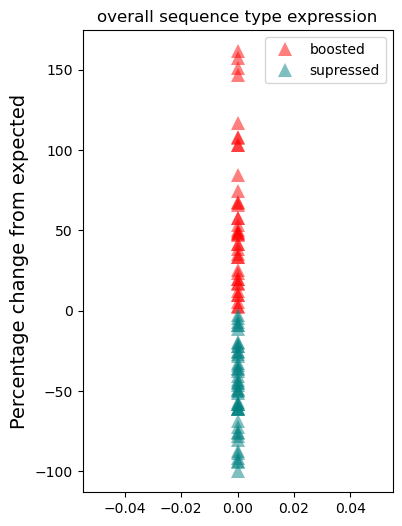

In [162]:
pcfe_values = all_mice_df.percentage_change_from_expected.values

# 2. Create a figure and a single axes
fig, ax = plt.subplots(figsize=(4, 6))


ax.plot(np.zeros(len(pcfe_values[pcfe_values > 0])),pcfe_values[pcfe_values > 0],'^', c ='red',markersize = 10,alpha = 0.5,label = 'boosted', markeredgewidth = 0)
ax.plot(np.zeros(len(pcfe_values[pcfe_values < 0])),pcfe_values[pcfe_values < 0],'^', c = 'teal', markersize = 10,alpha = 0.5,label = 'supressed', markeredgewidth = 0)

# ax.boxplot(pcfe_values[pcfe_values > 0], positions=[0.2], widths=0.05, patch_artist=True, boxprops=dict(facecolor='red', color='red'), medianprops=dict(color='#FED163'))
# ax.boxplot(pcfe_values[pcfe_values < 0], positions=[0.2], widths=0.05, patch_artist=True, boxprops=dict(facecolor='teal', color='teal'), medianprops=dict(color='#FED163'))


ax.set_ylabel('Percentage change from expected',fontsize = 14)
ax.set_title('overall sequence type expression')


ax.legend()

SaveFig('boosted_supressed.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


# make tracking plot

# functions 

In [53]:
from scipy.spatial import KDTree
from scipy.spatial import distance
import math

def get_tracking_data_EJT_data(full_org_dat_path):
    track_path = os.path.join(full_org_dat_path,'video/tracking/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'task' in tracking_file and '.h5' in tracking_file and not 'port' in tracking_file:
            task_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'port' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.9995)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 
        
    p1,p2,p3,p4,p5 = back_ports['port2'][0],back_ports['port1'][0],back_ports['port6'][0],back_ports['port3'][0],back_ports['port7'][0]
        
    return back_head_centre_df,p1,p2,p3,p4,p5

def get_dlc_data(Tracking_data_path,interp,val):
    # Load in '.h5' file:
    h5_read=pd.read_hdf(Tracking_data_path)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = {}
    for name in bodyparts:
        print(name)
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output[name] =[dat_interped]
    return output

def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)

def get_tracking_data_new_data(full_org_dat_path):
    track_path = os.path.join(full_org_dat_path,'video/tracking/')

    for tracking_file in os.listdir(track_path):
        if 'BACK' in tracking_file and not 'PORTS' in tracking_file and '.h5' in tracking_file:
            task_tracking_csv = os.path.join(track_path,tracking_file)
            break
    for tracking_file in os.listdir(track_path):
        if 'BACK' in tracking_file and 'PORTS' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.95)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 
        
    p1,p2,p3,p4,p5 = back_ports['Port2'][0],back_ports['Port1'][0],back_ports['Port6'][0],back_ports['Port3'][0],back_ports['Port7'][0]
        
    return back_head_centre_df,p1,p2,p3,p4,p5

def extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,exclude_port_1,exclude_port_2,exclude_port_3):

    start_ind = []
    end_ind = []


    index = 0
    while index < len(threshold_breaks[:-1]):
        break_ = threshold_breaks[index]
        if break_ == start_port and not threshold_breaks[index+1] ==start_port:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(index,threshold_breaks,frame_filter,end_port)
            # ignore any really bad ones that enter othe rports first, the -1 takes care of the excluded trajectories (gets rid of weird noise hwere the DLC tracking jumps outsid eof the task zone)
            if not exclude_port_1 in threshold_breaks[index:p3_ind] and not exclude_port_2 in threshold_breaks[index:p3_ind] and not exclude_port_3 in threshold_breaks[index:p3_ind] and not -1 in threshold_breaks[index:p3_ind]:
                if p3_ind != -1:
                    start_ind += [index-3]
                    end_ind += [p3_ind+3]
                    if not index == (p3_ind - 1):
                        index = p3_ind - 1
                    else:
                        index = p3_ind
                else:
                    index+=1
            else:
                index += 1
        else:
            index +=1

    return start_ind, end_ind

def find_next_val(index,threshold_breaks,frame_filter,port_type):
    p2_indicies = np.where(threshold_breaks == port_type)[0]
    try:
        p2_min_val = min(i for i in p2_indicies if i > index)
        distance = p2_min_val - index
    except:
        distance = 9999999
    if distance<frame_filter:
        return p2_min_val
    else:
        return -1
    
def process_raw_timestamps(full_org_dat_path):

    track_path = os.path.join(full_org_dat_path,'video/videos/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
            
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and '.csv' in tracking_file:
            timestammps_csv = os.path.join(full_track_path,tracking_file)
            break
        
    raw_cam_ts = pd.read_csv(timestammps_csv)

    if len(raw_cam_ts.columns) > 1:
        raw_cam_ts.columns = ['trigger', 'timestamps', 'blank']
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)
    else:
        raw_cam_ts[['trigger', 'timestamps', 'blank']] = raw_cam_ts.iloc[:, 0].str.split(expand=True)
        raw_cam_ts.drop(raw_cam_ts.columns[0], axis=1, inplace=True)
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)

    timestamp_df = process_camera_data(raw_cam_ts)
    
    return timestamp_df
    
def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    plt.close()
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_ts_raw.trigger.values[np.where(Camera_ts_raw.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state


def process_raw_timestamps(full_org_dat_path):

    track_path = os.path.join(full_org_dat_path,'video/videos/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
            
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and '.csv' in tracking_file:
            timestammps_csv = os.path.join(full_track_path,tracking_file)
            break
        
    raw_cam_ts = pd.read_csv(timestammps_csv)

    if len(raw_cam_ts.columns) > 1:
        raw_cam_ts.columns = ['trigger', 'timestamps', 'blank']
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)
    else:
        raw_cam_ts[['trigger', 'timestamps', 'blank']] = raw_cam_ts.iloc[:, 0].str.split(expand=True)
        raw_cam_ts.drop(raw_cam_ts.columns[0], axis=1, inplace=True)
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)

    timestamp_df = process_camera_data(raw_cam_ts)
    
    return timestamp_df

def get_sequence_regions(mir,awake_ppseq_base_path,sequence_order):
    standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
    overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mir:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    continuous_regions = []
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    for i,seq in enumerate(seq_order):
        ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
        continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

    # create new df 
    continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
    continuous_regions_df['sequence'] = seq_order
    return continuous_regions_df

    
def find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,mouse,radius):
    # find task relevant tracking periods
    #extract times mouse is close to each behavioural port


    current_x = back_head_centre_df.interped_x.values
    current_y = back_head_centre_df.interped_y.values

    port_positions = []
    for i in range(5):
        port = [p1,p2,p3,p4,p5][i]
        port_positions += [[np.median(port.interped_x),np.median(port.interped_y)]]
        
    port_centroids = port_positions
    
    if mouse == 'ap5R_1_4':
        port_centroids = [[665,651],
    [552,646],
    [669,549],
    [773,652],
    [779,551]]

    ############################################
    # fix port centroid 1 if it is missing: 
    port_centroids_fixed= []
    for i, item in enumerate(port_centroids):
        if sum(item) < 10:
            if i == 0:
                port_centroids_fixed += [[port_centroids[2][0],port_centroids[1][1]]]
        else:
            port_centroids_fixed += [item]
    port_centroids = port_centroids_fixed
    #####################################################
    
    coords = []
    for ind_,item in enumerate(current_x):
        coords += [[item,current_y[ind_]]]

    
    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(0,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        
        threshold_breaks[indicies] = ind_ + 1

    # exclude (by labelling with -1) any times the trajetcory goes outside of the port area
    half_dist = (port_centroids[0][-1] - port_centroids[4][-1])/2
    exclusion_mask = (np.array(current_y) < (port_centroids[0][-1] + half_dist)) * (np.array(current_y) > (port_centroids[4][-1] - half_dist))
    exclusion_inds = np.where(exclusion_mask == False)
    threshold_breaks[exclusion_inds] = -1
    
    return threshold_breaks,port_centroids,current_x,current_y, radius


def find_largest_continuous_region(positions, max_gap=5, circular_max=100):
    # Sort positions for easier processing
    positions = sorted(positions)
    
    # Identify continuous regions
    regions = []
    current_region = [positions[0]]
    
    for i in range(1, len(positions)):
        if positions[i] - positions[i - 1] < max_gap:
            current_region.append(positions[i])
        else:
            regions.append(current_region)
            current_region = [positions[i]]
    
    regions.append(current_region)  # Append the last region
    
    # Handle circular case (if the first and last regions can be merged)
    if regions and len(regions) > 1:
        first_region = regions[0]
        last_region = regions[-1]
        
        if (circular_max - last_region[-1] + first_region[0]) < max_gap:
            merged_region = last_region + first_region
            regions = regions[1:-1]  # Remove first and last
            regions.append(merged_region)
    
    # Find the largest region
    largest_region = max(regions, key=lambda r: r[-1] - r[0] if r[-1] >= r[0] else (r[-1] + circular_max - r[0]))
    
    # Determine start and end points
    start = largest_region[0]
    end = largest_region[-1]
    
    return start, end

def closest_points_distances(line1, line2):
    tree = KDTree(line2)
    dist, index = tree.query(line1)
    return dist

def find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer,radius):

    ## add to the start and end of each to ensure that the segmetns overlap - this is impotant for joining them into a representaitve continuous line 
    T1_start_ind = np.array(T1_start_ind) - buffer
    T2_start_ind = np.array(T2_start_ind) - buffer
    T3_start_ind = np.array(T3_start_ind) - buffer
    T4_start_ind = np.array(T4_start_ind) - buffer
    T1_end_ind = np.array(T1_end_ind) + buffer
    T2_end_ind = np.array(T2_end_ind) + buffer
    T3_end_ind = np.array(T3_end_ind) + buffer
    T4_end_ind = np.array(T4_end_ind) + buffer


    # plot these filtered trajectories:
    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(6, 4))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)

    segment1 = plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,'red',current_x,current_y)
    segment2 = plot_and_create_xy_segments(T2_start_ind,T2_end_ind,ax,'green',current_x,current_y)
    segment3 = plot_and_create_xy_segments(T3_start_ind,T3_end_ind,ax,'blue',current_x,current_y)
    segment4 = plot_and_create_xy_segments(T4_start_ind,T4_end_ind,ax,'grey',current_x,current_y)

    a_curve1 = interpolate_to_longest_and_find_average_curve(segment1,'None')
    a_curve2 = interpolate_to_longest_and_find_average_curve(segment2,'None')
    a_curve3 = interpolate_to_longest_and_find_average_curve(segment3,'None')
    a_curve4 = interpolate_to_longest_and_find_average_curve(segment4,'None')

    x = [point[0] for point in a_curve1]
    y = [point[1] for point in a_curve1]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve2]
    y = [point[1] for point in a_curve2]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve3]
    y = [point[1] for point in a_curve3]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve4]
    y = [point[1] for point in a_curve4]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    ax.invert_yaxis()
    
    return a_curve1,a_curve2,a_curve3,a_curve4

def plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,col,current_x,current_y):
    segment1 = []
    for i in range(len(T1_start_ind)):
        ax.plot(current_x[T1_start_ind[i]:T1_end_ind[i]],current_y[T1_start_ind[i]:T1_end_ind[i]],'-', color = col, alpha = 1)    
        x_vals = current_x[T1_start_ind[i]:T1_end_ind[i]]
        y_vals = current_y[T1_start_ind[i]:T1_end_ind[i]]
        xy_coords = []
        for index,x in enumerate(x_vals):
            xy_coords += [(x,y_vals[index])]
        segment1 += [xy_coords]
    return(segment1)

def interpolate_to_longest_and_find_average_curve(curves,num_points):
    
    if num_points == 'None':
        # Find the length of the longest curve
        max_length = max([len(curve) for curve in curves])
    else:
        max_length = num_points

    # Interpolate each curve to the length of the longest curve
    interpolated_curves = []
    for curve in curves:
        if len(curve) > 0:
            x = [point[0] for point in curve]
            y = [point[1] for point in curve]

            # find lots of points on the piecewise linear curve defined by x and y
            M = max_length
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)

            interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(interpolated_curves), y_sum / len(interpolated_curves)])

    return average_curve

def join_curves(curve1, curve2, cut=True, overlap_thresh=0.1):
    """
    Join two curves at the closest points if they touch near endpoints (within first/last 20%).
    Otherwise, join endpoints.
    """
    point1, point2 = find_closest_points(curve1, curve2, cut)

    # distance check (touching if close enough)
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:
        index1 = curve1.index(point1.tolist())
        index2 = curve2.index(point2.tolist())

        # Check if the overlap point is near start or end of curve1
        near_end_curve1 = (index1 <= len(curve1) * overlap_thresh) or (index1 >= len(curve1) * (1 - overlap_thresh))
        # Same for curve2
        near_end_curve2 = (index2 <= len(curve2) * overlap_thresh) or (index2 >= len(curve2) * (1 - overlap_thresh))

        if near_end_curve1 or near_end_curve2:
            print("Overlap detected near curve ends")
            return curve1[:index1+1] + curve2[index2:]
    
    # Default: just concatenate fully
    return curve1 + curve2

def join_make_full_circle(curve1, end_segment_length ,cut = False):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1[0:end_segment_length], curve1[-1*end_segment_length::], cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected!')
        index1 = curve1[0:100].index(point1.tolist())
        index2 = curve1[-100::].index(point2.tolist())
        index2 = index2 + (len(curve1) - 100)
        return curve1[index1:index2]
    else:
        # Join by endpoints
        return curve1 + [curve1[0]]
    
def find_closest_points(curve1, curve2, cut):
    """Find the closest points between two curves."""
    if cut:#only use the very end of the line to do the joining procedure to prevent verlap errors
        curve1 = np.array(curve1[-100::])
        curve2 = np.array(curve2[0:100])
    else:     
        curve1 = np.array(curve1)
        curve2 = np.array(curve2)
    
    dist_matrix = distance.cdist(curve1, curve2)
    min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    return curve1[min_idx[0]], curve2[min_idx[1]]

def resample_curve(complete_average, num_points):
    """
    Resample the given curve so that it has `num_points` evenly spaced points.
    """
    a_curve_copy = np.array(complete_average.copy())
    data_points = len(a_curve_copy)
    
    # Compute cumulative distance along the curve
    distances = [0]
    for i in range(1, data_points):
        distances.append(distances[-1] + math.dist(a_curve_copy[i], a_curve_copy[i-1]))
    total_length = distances[-1]
    
    # Create new evenly spaced distance values
    new_distances = np.linspace(0, total_length, num_points)
    
    # Interpolate new points
    x_vals = [p[0] for p in a_curve_copy]
    y_vals = [p[1] for p in a_curve_copy]
    x_interp = np.interp(new_distances, distances, x_vals)
    y_interp = np.interp(new_distances, distances, y_vals)
    
    return np.column_stack((x_interp, y_interp))

def fourier_smooth_closed(points, keep_freq=10):
    points = np.asarray(points)
    n = len(points)
    x, y = points[:,0], points[:,1]

    Xf = np.fft.rfft(x)
    Yf = np.fft.rfft(y)

    Xf[keep_freq:] = 0
    Yf[keep_freq:] = 0

    x_smooth = np.fft.irfft(Xf, n)
    y_smooth = np.fft.irfft(Yf, n)

    return np.column_stack([x_smooth, y_smooth])

def shift_curve_start(resampled_curve, p5, radius=45):
    """
    Shift the curve start to the first point that exits a circle of given radius from p5.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param p5: Tuple (x, y) representing the circle centroid
    :param radius: Radius of the circle
    :return: Shifted curve starting from the first point outside the circle
    """
    # Find the first index where the point is outside the circle
    for i, point in enumerate(resampled_curve):
        if math.dist(point, p5) > radius:
            break  # Found the new start index
    
    # Rearrange the curve so this new point becomes the start
    shifted_curve = np.vstack((resampled_curve[i:], resampled_curve[:i]))  # Maintain order
    
    return shifted_curve

def plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids):
    fig, axs = plt.subplots(1, 2,figsize=(8, 2))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius_used, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)
        if ind == 0:
            x = [point[0] for point in complete_average]
            y = [point[1] for point in complete_average]
            ax.plot(x, y, '--', color ='black',alpha = 1)
        if ind == 1:
            x = [point[0] for point in standard_av_curve]
            y = [point[1] for point in standard_av_curve]
            ax.plot(x, y, 'x', color ='black',alpha = 1)

        ax.invert_yaxis()
        
def closest_points(target, points, threshold):
    import math
    closest = []
    indicies = []
    for index,point in enumerate(points):
        distance = math.dist(target,point)
        if distance <= threshold:
            closest.append(point)
            indicies.append(index)
    return closest,indicies

def plot_percentage_interval(resampled_curve, percentages,port_centroids,ax,sequence_name,colour_,radius_used):
    """
    Plot the full resampled curve and highlight the region between two percentage points.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List [start%, end%] defining the highlighted region
    """
    num_points = len(resampled_curve)
    start_idx = int(percentages[0] / 100 * (num_points - 1))
    end_idx = int(percentages[1] / 100 * (num_points - 1))

    # Handle case where interval wraps around (e.g., 97% to 14%)
    if start_idx <= end_idx:
        highlight_indices = range(start_idx, end_idx + 1)
    else:
        highlight_indices = list(range(start_idx, num_points)) + list(range(0, end_idx + 1))

    # Extract x, y coordinates
    x_vals, y_vals = resampled_curve[:, 0], resampled_curve[:, 1]

    # Plot full curve
    # ax.plot(x_vals, y_vals, color='black', linewidth=1, label="Full Curve")

    # Highlight section
    highlighted_x = x_vals[list(highlight_indices)]
    highlighted_y = y_vals[list(highlight_indices)]
    ax.plot(highlighted_x, highlighted_y, color=colour_, linewidth=5, label="Highlighted Region")

    # # Scatter start and end points
    # ax.scatter([x_vals[start_idx], x_vals[end_idx]], 
    #             [y_vals[start_idx], y_vals[end_idx]], 
    #             color='blue', zorder=3, label="Start/End Points")

    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, radius_used, color='grey', alpha = 0.2)
        ax.add_patch(circle1)

        
    ax.invert_yaxis()
    
    
def get_percentage_points(resampled_curve, percentages):
    """
    Get the points at specific percentage locations along the resampled curve.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List of percentages (0-100) where points should be extracted
    :return: List of (x, y) points corresponding to the given percentages
    """
    num_points = len(resampled_curve)
    indices = [int(p / 100 * (num_points - 1)) for p in percentages]  # Convert percentage to index
    return resampled_curve[indices]

# load data for mouse

178_1_7
EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
head_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
left_ear
function exiting
function exiting
right_ear
function exiting
function exiting
tail_base
function exiting
function exiting
port1
function exiting
function exiting
port2
function exiting
function exiting
port3
function exiting
function exiting
port6
function exiting
function exiting
port7
function exiting
function exiting
Frames dropped = 4
Overlap detected near curve ends


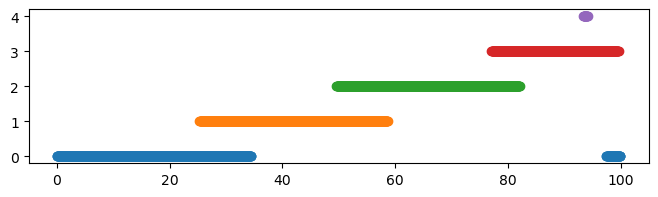

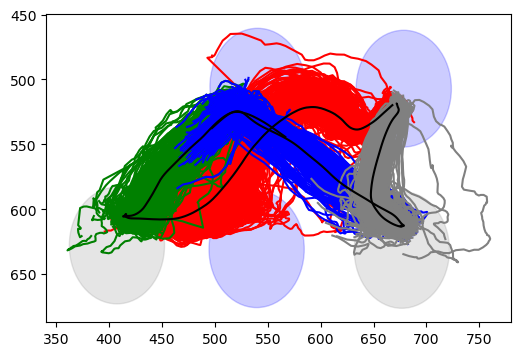

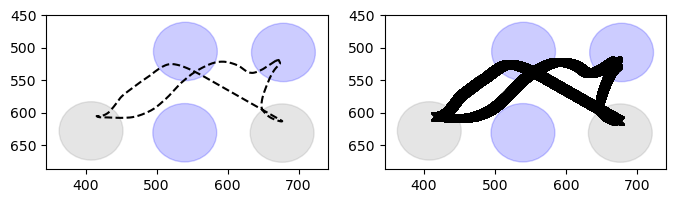

In [42]:
mouse = '178_1_7'

# load sequence order
sequence_order = pd.read_csv(r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\" + r'\sequence_order.csv')
#### plot average tracking colored by sequence region
print(mouse)
mouse_path_dict = find_data_paths('Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\',mouse)

full_org_dat_path = mouse_path_dict[mouse]['full_org_dat_path']
awake_path = mouse_path_dict[mouse]['awake_path']

############################# movement variability for each motif region ####################
## TRACKING PREP - laod in data, find average curves etc. 
#############################################################################################

try:
    back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_EJT_data(full_org_dat_path)
except:
    back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_new_data(full_org_dat_path)

if not mouse == '148_2_2':
    # search for the timestamps df, if it doesnt exist (it wont for the old data, only for the newer recordings) then remake it
    camera_timestamps_df = None
    for files in os.listdir(full_org_dat_path + r'\video\videos\\'):
        if '.csv' in files:
            if 'BACK' in files:
                camera_timestamps_df = pd.read_csv(full_org_dat_path + r'\video\videos\\'+ files)
    if camera_timestamps_df is None:
        # process/uncycle the raw timestamps
        camera_timestamps_df = process_raw_timestamps(full_org_dat_path)
        
# get continuous regions information
continuous_regions_df = get_sequence_regions(mouse,awake_path,sequence_order)

# find task relevant tracking periods, extract times mouse is close to each behavioural port
if 'epoch' in list(camera_timestamps_df):
    task_mask = camera_timestamps_df.epoch == 'task'

    # find task relevant tracking periods, extract times mouse is close to each behavioural port
    threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df[task_mask],p1[task_mask],p2[task_mask],p3[task_mask],p4[task_mask],p5[task_mask],mouse,radius = 45)
else:
    # find task relevant tracking periods, extract times mouse is close to each behavioural port
    threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,mouse,radius = 45) 


## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
fps = 1/np.nanmean(np.diff(camera_timestamps_df['Time Stamps'].values))
time_filter = 2 #in s
frame_filter = int(time_filter / (1/fps))


#we know when the mouse is close to each port, so find times when the mouse goes from port to port 
start_port,end_port = 5,2
T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
start_port,end_port = 2,3
T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
start_port,end_port = 3,4
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
start_port,end_port = 4,5
T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)

# add alteration for this mouse as it messes up 
if mouse in ['seq006_1_5','seq007_1_2','seq006_1_8','seq006_1_9','seq006_1_4','seq006_1_7','seq006_1_6','seq006_1_11','270_1_2']:
    start_port,end_port = 3,4
    T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)
    start_port,end_port = 4,5
    T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)


# find average curves by taking traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points, then for each point in each trajectory find the average xy position to create an average trajectory line 
a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)

new = join_curves(a_curve1, a_curve2,cut = True)
if not mouse in ['178_1_7','seq006_1_4','seq006_1_5','seq006_1_6','seq006_1_8','seq006_1_9','seq006_1_10','seq007_1_1','270_1_2','149_1_1','178_1_4','178_1_8','178_2_1','178_2_2']:
    new = join_curves(new, a_curve3,cut = True)
new = join_curves(new, a_curve4,cut = True)
# join the two ends together to make a complete circle
if not mouse in ['seq006_1_4','seq006_1_6','seq006_1_5','seq006_1_8','seq006_1_9','seq006_1_10','seq006_1_11','seq007_1_1']:
    complete_average = join_make_full_circle(new,100)
else:
    complete_average = join_make_full_circle(new,50)
    # smooth it for the mice where the extracted curve is a bit noisy
    complete_average = fourier_smooth_closed(complete_average)

#interpolate to make standardspace:
standard_av_curve = resample_curve(complete_average, num_points = 10000)

# shift the start point of the curve so that is the first time the mous eleaves port 5 radius
standard_av_curve = shift_curve_start(standard_av_curve,port_centroids[-1])

# plot this stuff to check it looks okay
plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids)

# load in the seq colours 
seq_colours = np.load(mouse_path_dict[mouse]['awake_path']+ r'/analysis_output/reordered_recolored/colors',allow_pickle=True)



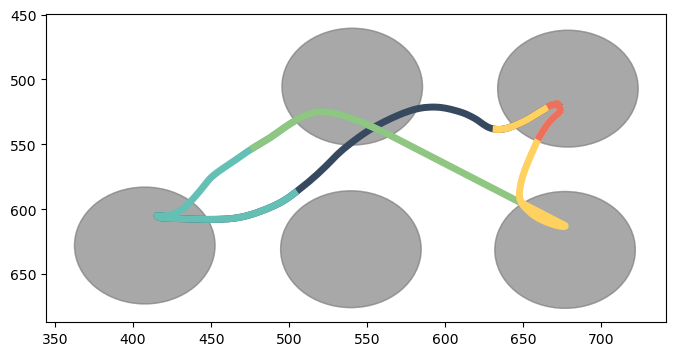

In [156]:

start_end_intermediate = []
fig, axs = plt.subplots(1, 1, figsize=(8 , 4))

num_intermediate_points = 5
for i, row in continuous_regions_df.iterrows():
    buffer_ = 2  # 2% buffer on each side
    start = row.start - buffer_
    end = row.end + buffer_
    
    # Handle circular nature at 100%
    if start < 0:
        start += 100
    if end > 100:
        end -= 100
    
    # Compute percentage points
    if start < end:
        positions = np.linspace(start, end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
    else:  # Wraps around 100%
        positions = np.linspace(0, (100-start)+end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
        positions = start + positions
        positions = [position-100 if position>100 else position for position in positions]
    
    
    intermediate_xy = get_percentage_points(standard_av_curve, positions)
    s_, e_ = get_percentage_points(standard_av_curve, [start, end])
    
    # Plot
    plot_percentage_interval(standard_av_curve, [start, end], port_centroids, axs, row.sequence, seq_colours[int(row.sequence) + 1],radius_used)
    
# save fig 
SaveFig('tracking_example.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# awake/replay breakdown 

In [101]:
def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def split_sequence_events(seq_event_dfs):
    # Split sequence events into a dictionary by sequence type.
    # Each key is the sequence type, and the value is a list of DataFrames for those events
    seq_events = {}
    for event in seq_event_dfs:
        # add the sequence type as a key if it doesn't exist
        if str(int(event.sequence_type_adjusted.values[0])) not in seq_events:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))] = [event]
        else:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))].append(event)
    return seq_events

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted

178_1_7
EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_43124\3437020191.py:14: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk1_8300to10000
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------
chunk2_10500to11200
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------
chunk3_13300to14300
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------


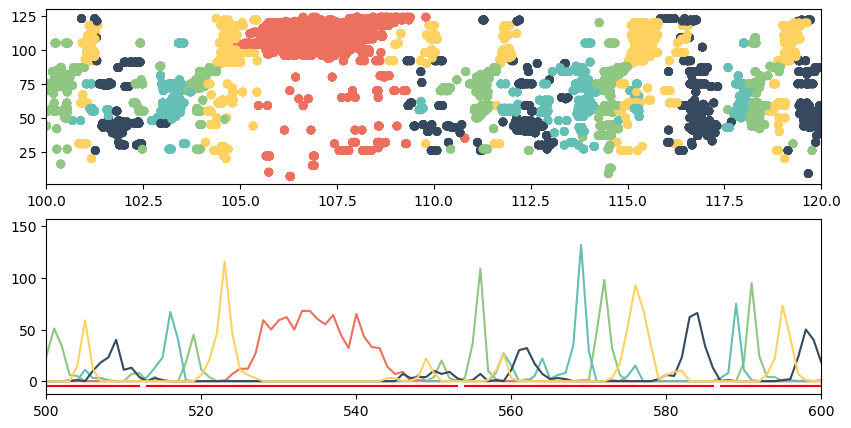

In [153]:
import pickle 

#### plot breakdown of awake/replays 
mouse = '178_1_7'

# load sequence order
sequence_order = pd.read_csv(r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\" + r'\sequence_order.csv')
#### plot average tracking colored by sequence region
print(mouse)
mouse_path_dict = find_data_paths('Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\',mouse)

### load in awake ppseq data for mouse
with open(mouse_path_dict[mouse]['awake_path'] + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
    unmasked_spikes_df = pickle.load(handle)
    
with open(mouse_path_dict[mouse]['awake_path'] + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
    awake_neuron_order = pickle.load(handle)

colors = pd.read_pickle(mouse_path_dict[mouse]['awake_path'] + r"\analysis_output\reordered_recolored\\" + 'colors')

#load json
import json
params = None
for file in os.listdir(mouse_path_dict[mouse]['awake_path'] + r'\trainingData\\'):
    if 'json' in file:
        param_path = os.path.join(mouse_path_dict[mouse]['awake_path'] + r'\trainingData\\', file)
        with open(param_path,'r') as f:
            params = json.load(f)
awake_time_span = params['time_span'][0]

# cluster the awake spikes into individual sequence events
seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120]) 
## spit the sequence events into individual sequence types
seq_events_dict = split_sequence_events(seq_event_dfs)


##### get replay events

current_mouse_replay_path = mouse_path_dict[mouse]['sleep_path'] + '\\_final_analysis_output'
    
if '_final_analysis_output' in os.listdir(mouse_path_dict[mouse]['sleep_path']):
    # load in sleep start time 
    sleep_time_point_df = pd.read_csv(remove_last_folder(mouse_path_dict[mouse]['sleep_path']) + '\sleep_time_points.csv')
    current_sleep_start = sleep_time_point_df['approx_sleep_start'][np.where(sleep_time_point_df.mir == mouse)[0][0]]
    params_file = mouse_path_dict[mouse]['sleep_path'] + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
    
    # load sequence order
    sequence_order = pd.read_csv(r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\" + r'\sequence_order.csv')
    
    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mouse:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)

total_seqs_chunk = []
## loop across all chunk files ################################
for chunk_number,file in enumerate(os.listdir(current_mouse_replay_path)):
    if not 'chunk' in file:
        continue
    print(file)
    current_data_path = current_mouse_replay_path + '\\' + file + '\\'
    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
    data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')

    ###### FILTERING AND MASKING ##################################################################''
    ## filter this data for sequential ordering
    sequential_condition = data.ordering_classification == 'sequential'
    # filter is set up so that any true will carry forward 
    filtered_chunk_data = data[sequential_condition].reset_index()
    
    ## REM / NREM times only
    # load in sleep state scoring
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(mouse)
    # get relevant rem/nrem times for chunk
    chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
    chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
    # get spike times relative to chunk:
    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # find inds of spike times that are in nrem and rem periods:
    idx  = []
    for start,end in chunk_nrem_times + chunk_rem_times:
        idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
    # filter the data frame, only keeping the rows in idx
    filtered_chunk_data = filtered_chunk_data.iloc[idx]
    filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
    # get rid of the stupid unnamed columns
    filtered_chunk_data = filtered_chunk_data.loc[:, ~filtered_chunk_data.columns.str.startswith('Unnamed')]
    
    # get number of seqs for each seuqnece 
    total_seqs = []
    for seq_id in seq_order:
        seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
        seq_chunk_data= seq_chunk_data.reset_index(drop=True)
        total_seqs += [len(seq_chunk_data)]
    total_seqs_chunk += [total_seqs]


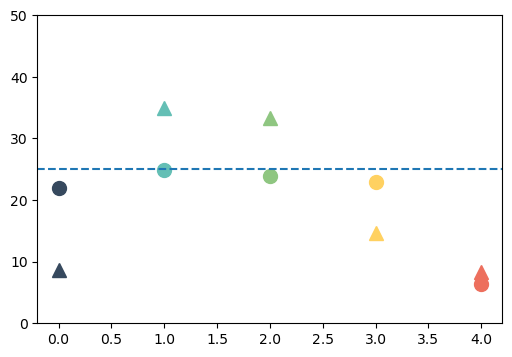

In [159]:
awake_totals = []
for seq_id in seq_order:
    awake_seqs = seq_events_dict[str(seq_id+1)]
    awake_totals+=[len(awake_seqs)]
awake_proportions = np.array(awake_totals)/sum(awake_totals)

total_seqs = []
for i in range(len(seq_order)):
    total_seqs += [sum([item[i] for item in total_seqs_chunk])]
replay_proportions = np.array(total_seqs)/sum(total_seqs)

fig, ax = plt.subplots(1, 1, figsize=(6 , 4))

col = np.array(seq_colours)[np.array(seq_order)+1]

for i,item in enumerate(awake_proportions):
   ax.plot(i,awake_proportions[i]*100,'o', color = col[i], markersize = 10)
   ax.plot(i,replay_proportions[i]*100,'^', color = col[i], markersize = 10)
ax.axhline(25, linestyle = '--')
ax.set_ylim(0,50)
   
# save fig 
SaveFig('awake_sleep_proportions.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")